In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import pathlib

In [2]:
output_dir = '../results_Mar4/'
pathlib.Path(output_dir).mkdir(exist_ok=True)

In [3]:
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')
traj_A = np.load('../results_final_Dec22/trajectories_A_extreme.npy')
traj_T = np.load('../results_final_Dec22/trajectories_T_extreme.npy')
with open('../results_final_Dec22/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
X_phate = scaler.transform(adata.obsm['X_phate'])
traj_A_gene_all = np.load('../results_final_Dec22/traj_gene_space_A.npy')
traj_T_gene_all = np.load('../results_final_Dec22/traj_gene_space_T.npy')

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [4]:
granger_df_all_T = pd.read_csv('../results_final_Jan15/granger_draft_T_signed_score.csv', index_col=0)
granger_df_all_T_pvals = pd.read_csv('../results_final_Jan15/granger_draft_T_p.csv', index_col=0)
granger_df_all_T_pvals.index = granger_df_all_T_pvals.index.str.replace('_x', '')
cluster_df = pd.read_csv('../results_final_Jan30/cluster_df_extreme_T_draft.csv', index_col=0)
df_reordered = pd.read_csv('../results_final_Jan30/granger_draft_heatmap_df_reordered.csv', index_col=0)
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')

tf_reordered_cluster = pd.DataFrame(index=df_reordered.index)
tf_reordered_cluster['cluster'] = tf_reordered_cluster.index.map(cluster_df['cluster'])
gene_reordered_cluster = pd.DataFrame(index=df_reordered.columns)
gene_reordered_cluster['cluster'] = gene_reordered_cluster.index.map(cluster_df['cluster'])
df_reordered_filtered = df_reordered.copy()

# Create boolean mask for TF clusters > gene clusters using broadcasting
tf_clusters = tf_reordered_cluster['cluster'].values[:, np.newaxis]
gene_clusters = gene_reordered_cluster['cluster'].values
mask = tf_clusters > gene_clusters

# Apply mask to set values to 0 
df_reordered_filtered.values[mask] = 0


In [15]:
# [Zeb1, CDH1, Epcam, Esrra and Cav1, p53 and Bax]
genes_to_plot = gene_reordered_cluster.index
assert all([g in adata.var_names for g in genes_to_plot])
# for g in genes_to_plot:
#     print(g, g in adata.var_names)

gene_mask = np.isin(adata.var_names, genes_to_plot)
traj_A_gene = traj_A_gene_all[:, :, gene_mask]
traj_T_gene = traj_T_gene_all[:, :, gene_mask]
gene_names = adata.var_names[gene_mask]

traj_A_mean = np.mean(traj_A_gene, axis=1)
traj_A_std = np.std(traj_A_gene, axis=1)
traj_T_mean = np.mean(traj_T_gene, axis=1)
traj_T_std = np.std(traj_T_gene, axis=1)

In [11]:
traj_T_mean.shape

(100, 5273)

In [27]:
traj_T_fano = traj_T_mean.var(axis=0) /(traj_T_mean.mean(axis=0) + 1e-8)
traj_T_fano_df = pd.DataFrame(traj_T_fano, index=gene_names, columns=['fano_factor'])
traj_T_fano_df['cluster'] = traj_T_fano_df.index.map(gene_reordered_cluster['cluster'])

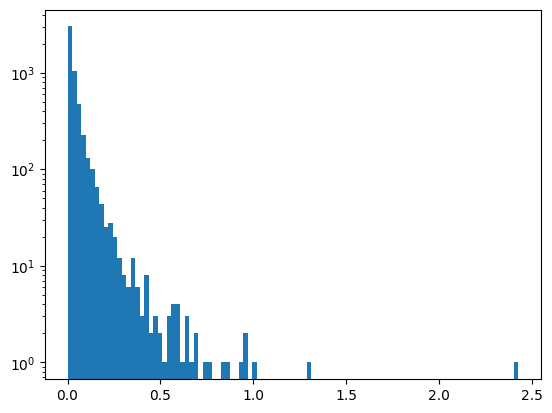

In [24]:
plt.hist(traj_T_fano, 100, log=True);

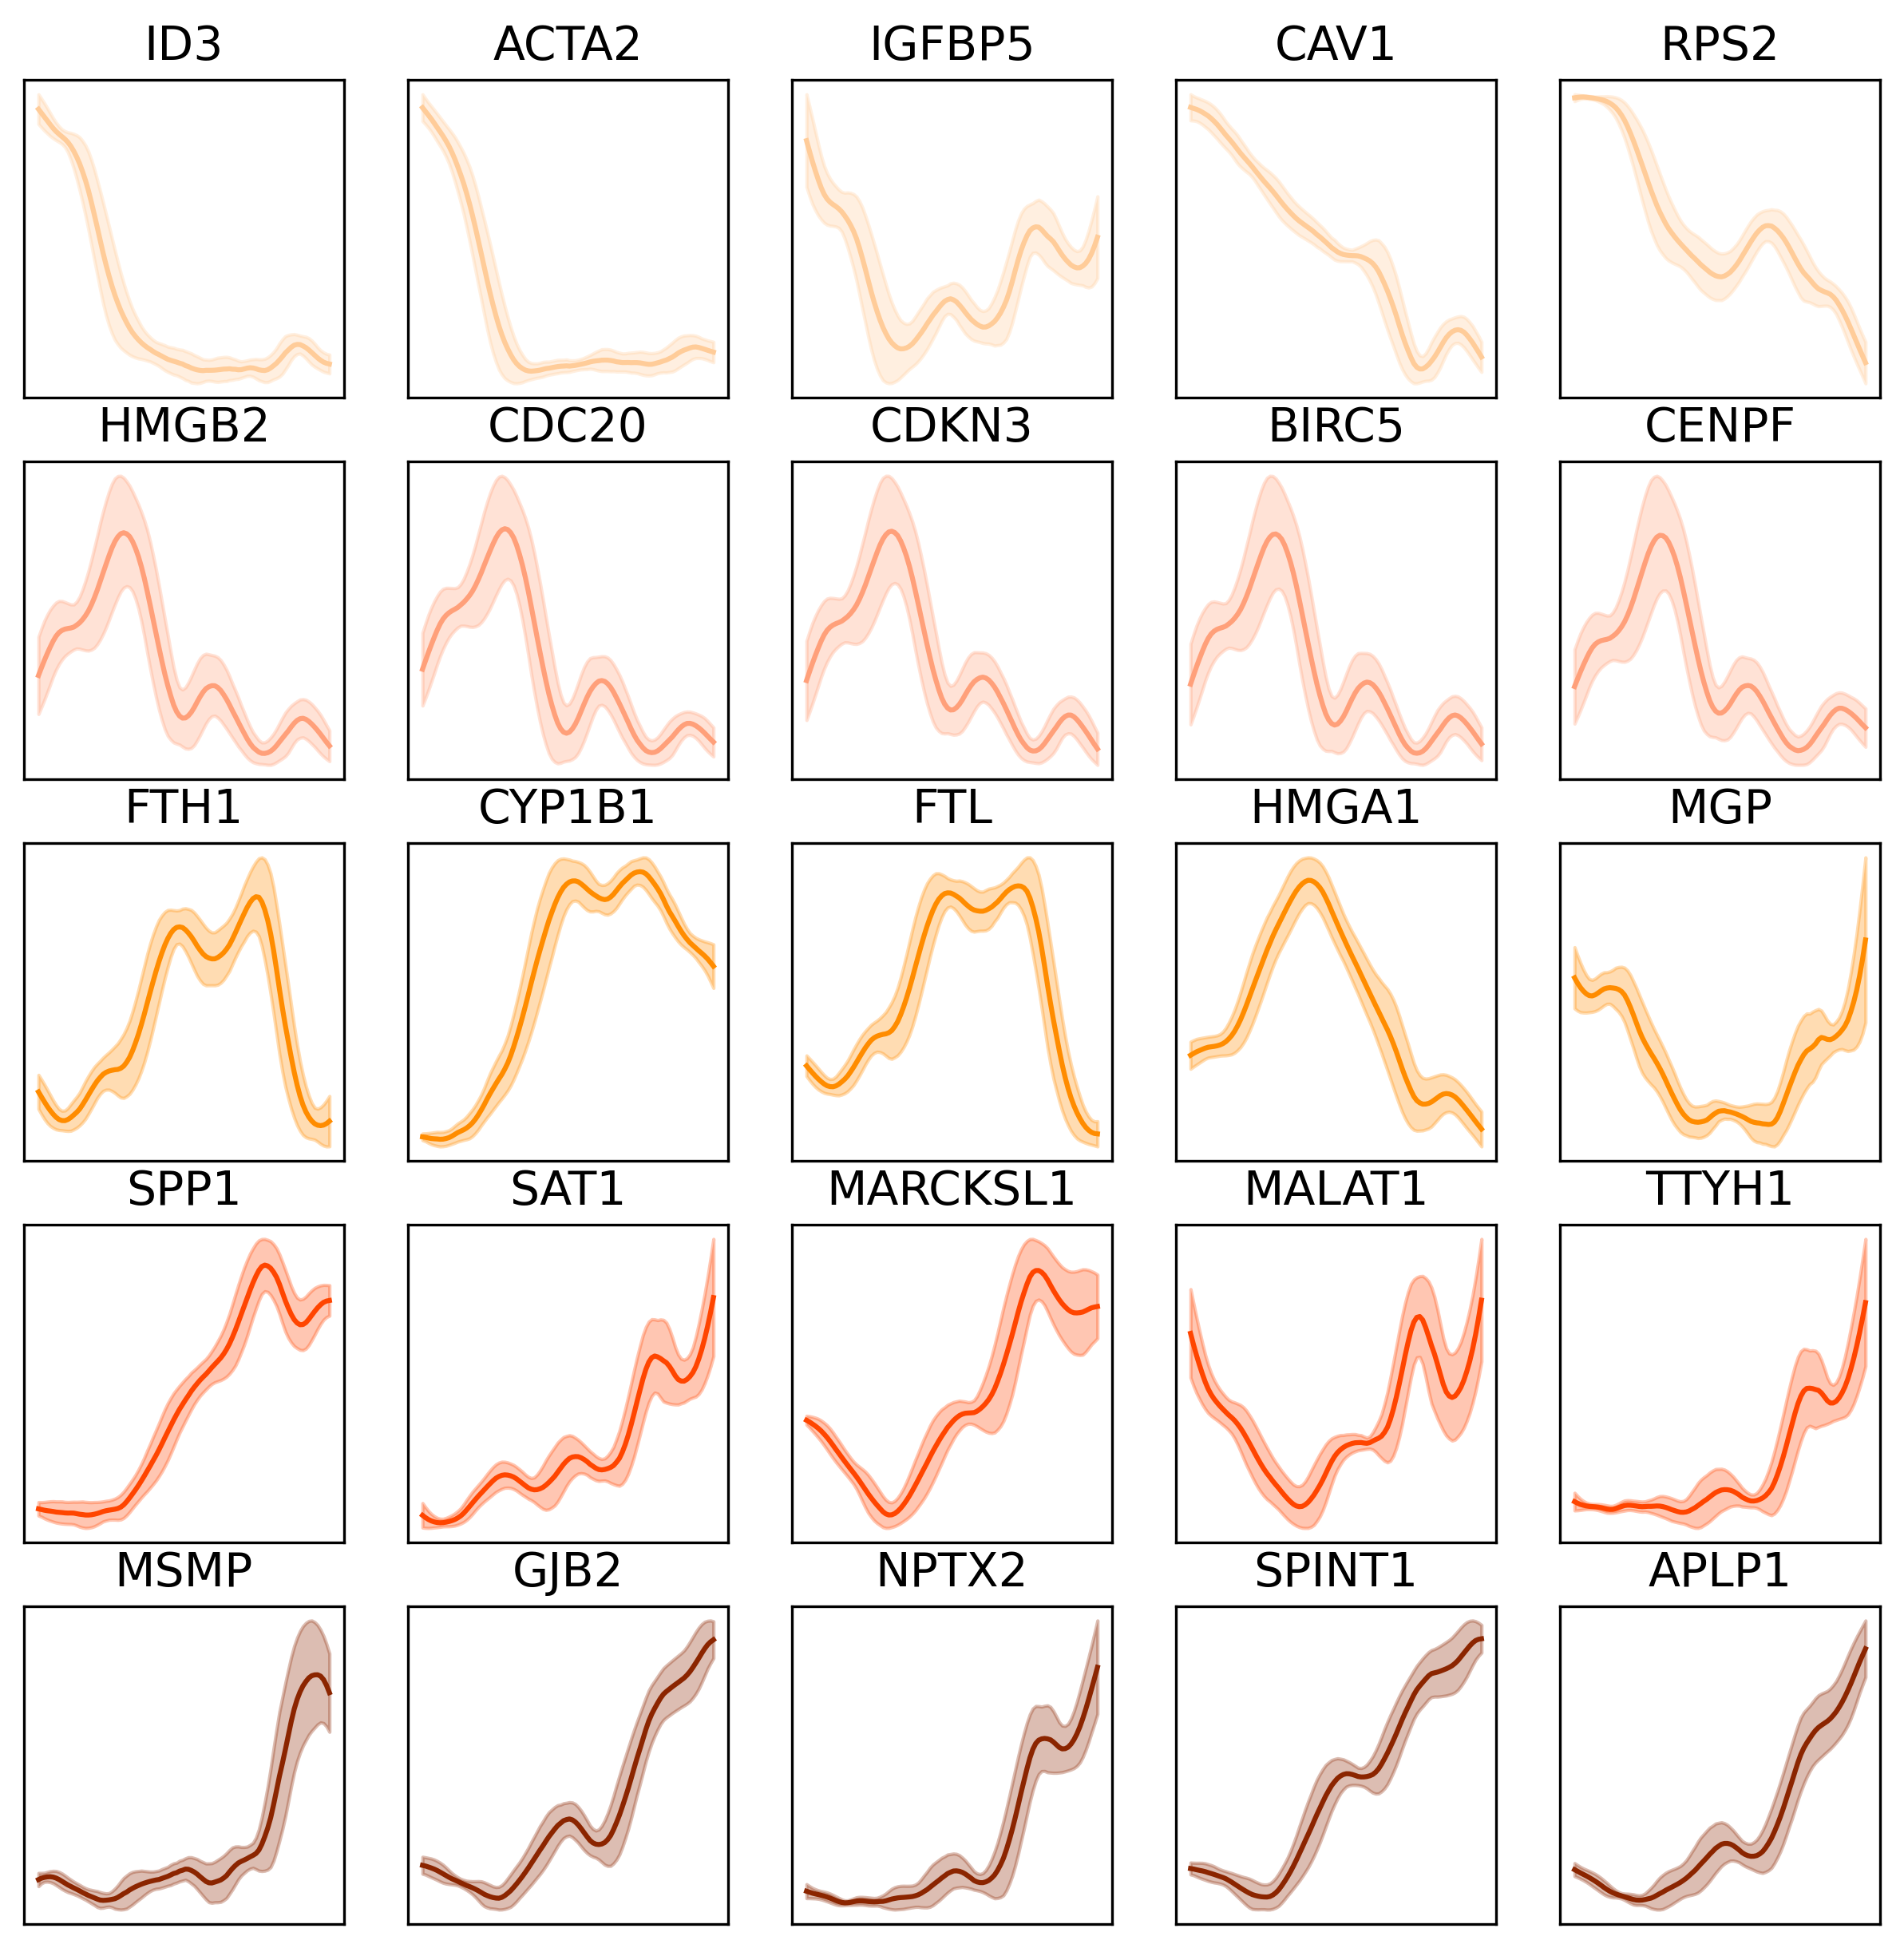

Cluster 0.0 top genes: ID3, ACTA2, IGFBP5, CAV1, RPS2
Cluster 1.0 top genes: HMGB2, CDC20, CDKN3, BIRC5, CENPF
Cluster 2.0 top genes: FTH1, CYP1B1, FTL, HMGA1, MGP
Cluster 3.0 top genes: SPP1, SAT1, MARCKSL1, MALAT1, TTYH1
Cluster 4.0 top genes: MSMP, GJB2, NPTX2, SPINT1, APLP1


In [51]:
# Group by cluster and get the top genes by fano factor for each cluster
# First sort the dataframe by fano_factor
sorted_df = traj_T_fano_df.sort_values('fano_factor', ascending=False)
# Then group by cluster and get top 5 genes per cluster
grouped = sorted_df.groupby('cluster')
top_genes_per_cluster = {}
for cluster, group in grouped:
    top_genes_per_cluster[cluster] = group.head(5).index.tolist()

# Define custom colors for each cluster
custom_oranges = [
    "#FFCC99",  # Light Peach
    "#FFA07A",  # Light Salmon
    "#FF8C00",  # Dark Orange
    "#FF4500",  # Orange Red
    "#8B2500"   # Deep Burnt Orange
]

# Get all unique clusters and sort them
clusters = sorted(top_genes_per_cluster.keys())
num_clusters = len(clusters)
num_genes_per_cluster = 5

# Create one figure with subplots, each row is a cluster
fig, axes = plt.subplots(num_clusters, num_genes_per_cluster, 
                         figsize=(num_genes_per_cluster * 2, num_clusters * 2), 
                         dpi=300)

# Plot trajectories for top genes in each cluster
for i, cluster in enumerate(clusters):
    genes = top_genes_per_cluster[cluster]
    cluster_color = custom_oranges[int(cluster) % len(custom_oranges)]
    
    # Add row title for the cluster
    # fig.text(0.01, 1 - (i + 0.5) / num_clusters, f"Cluster {cluster}", 
            #  va='center', ha='left', fontsize=12, fontweight='bold')
    
    for j, gene in enumerate(genes):
        gene_idx = np.where(gene_names == gene)[0][0]
        ax = axes[i, j]
        ax.plot(traj_T_mean[:, gene_idx], color=cluster_color)
        ax.fill_between(range(traj_T_mean.shape[0]), 
                        traj_T_mean[:, gene_idx] - traj_T_std[:, gene_idx], 
                        traj_T_mean[:, gene_idx] + traj_T_std[:, gene_idx], 
                        alpha=0.3, color=cluster_color)
        ax.set_title(gene, fontsize=14)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

# plt.tight_layout(rect=[0.03, 0, 1, 1])  # Adjust layout to make room for row titles
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig(f'{output_dir}/5B-top5-trend-per-cluster.pdf', dpi=300, transparent=True)
plt.show()

# Print the top genes per cluster for reference
for cluster, genes in top_genes_per_cluster.items():
    print(f"Cluster {cluster} top genes: {', '.join(genes)}")

In [47]:
output_dir

'../results_Mar4/'